In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # This optional package makes plots prettier

import openmc

## Summary and statepoint files

OpenMC by default outputs two types of HDF5 files: statepoints and summaries.  Statepoints mostly contain tally data.  Summaries mostly contain information about materials and geometry.

### Summary

In [2]:
su = openmc.Summary('summary.h5')

The summary contains the entire geometry model that was used to run OpenMC. 

In [3]:
su.geometry

In addition, the `Summary` includes properties to quickly and easily access the `Materials`, `Cells`, `Universes`, etc. directly. The following are included as properties in the `Summary`:

* `materials` - `dict` of `Material` objects indexed by ID
* `surfaces` - `dict` of `Surface` objects indexed by ID
* `cells` - `dict` of `Cell` objects indexed by ID
* `universes` - `dict` of `Universe` objects indexed by ID
* `lattices` - `dict` of `Lattice` objects indexed by ID

For example, let's inspect the `materials`:

In [4]:
su.materials[:2]

[Material
 	ID             =	10000
 	Name           =	uo2
 	Temperature    =	None
 	Density        =	0.06893778152090038 [atom/b-cm]
 	S(a,b) Tables  
 	Nuclides       
 	U235           =	0.0005581536764737342 [ao]
 	U238           =	0.02241727940725633 [ao]
 	O16            =	0.045962348437170314 [ao]
 	Elements       , Material
 	ID             =	10001
 	Name           =	zirconium
 	Temperature    =	None
 	Density        =	0.04323990925294387 [atom/b-cm]
 	S(a,b) Tables  
 	Nuclides       
 	Zr90           =	0.022246933310639618 [ao]
 	Zr91           =	0.004851517818180302 [ao]
 	Zr92           =	0.007415644436879874 [ao]
 	Zr94           =	0.007515096228161645 [ao]
 	Zr96           =	0.0012107174590824284 [ao]
 	Elements       ]

For relatively large models, the number of `Materials`, `Cells`, `Universes`, etc. may be unwieldy to digest in such a format. However, if we give our objects names (or labels) then we can easily retrieve them directly from the `Geometry`. For example, let's retrieve the `Material` named `'uo2'`:

In [5]:
fuel = su.geometry.get_materials_by_name('uo2')
print(fuel)

[Material
	ID             =	10000
	Name           =	uo2
	Temperature    =	None
	Density        =	0.06893778152090038 [atom/b-cm]
	S(a,b) Tables  
	Nuclides       
	U235           =	0.0005581536764737342 [ao]
	U238           =	0.02241727940725633 [ao]
	O16            =	0.045962348437170314 [ao]
	Elements       
]


### Statepoint

Let's begin by loading the statepoint HDF5 file for batch 100 into the Python API's `openmc.StatePoint` class:

In [6]:
sp = openmc.StatePoint('statepoint.100.h5')

The statepoint file contains some metadata like the date and time that it was written.

In [7]:
sp.date_and_time

'2017-02-24 14:51:55'

OpenMC computes a number of estimators for the multiplication factor $k_{eff}$. Each of these estimators is stored as an attribute in the `StatePoint` class. We can report an ensemble-averaged estimator through the `StatePoint.k_combined` property with an `ndarray` storing the mean and uncertainty.

In [8]:
sp.k_combined

array([  1.27296671e+00,   8.08903971e-04])

#### Access Fission Source Sites

The `StatePoint` contains all of the fission source sites for the corresponding batch in the `source` NumPy array. This array includes the following information about each source:

* Energy (`"E"`)
* Location (`"xyz"`)
* Direction (`"uvw"`)

Let's inspect the energies (in MeV) indexed by key `"E"`:

In [9]:
sp.source['E']

array([  189985.70998802,   388832.69492488,  1168505.54509699, ...,
         601204.10213271,  4892278.40128772,   879207.73572189])

To make things more interesting, we can use NumPy and Matplotlib to plot a histogram of those energies in the `source` array.

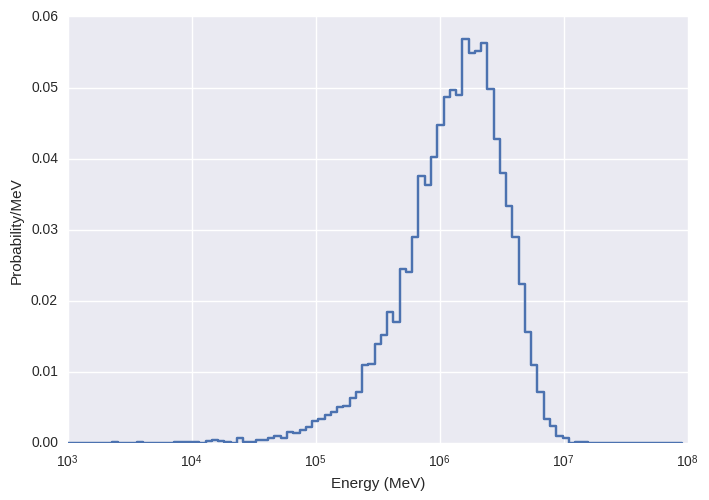

In [10]:
# Create log-spaced energy bins from 1 keV to 100 MeV
energy_bins = np.logspace(np.log10(1e3), np.log10(1e8), 100)

# Calculate pdf for source energies
probability, bin_edges = np.histogram(sp.source['E'], energy_bins, density=True)

# Plot source energy PDF
plt.semilogx(energy_bins[:-1], probability*np.diff(energy_bins), linestyle='steps')
plt.xlabel('Energy (MeV)')
plt.ylabel('Probability/MeV')

## Tally data analysis

### Getting Tally objects from the statepoint

Our `StatePoint` also has a number of different `Tally` objects stored in the `StatePoint.tallies` as a `dict`. We can inspect one the `Tally` objects by directly indexing into `tallies` with the appropriate ID:

In [11]:
print(sp.tallies[10000])

Tally
	ID             =	10000
	Name           =	mesh fission
	Filters        =	MeshFilter
	Nuclides       =	U235 U238 
	Scores         =	['fission']
	Estimator      =	tracklength



Sometimes you may not know the ID number of the tally.  So in order to find the tally you need, there is a `get_tally(...)` method which allows one to retrieve a `Tally` object with an arbitrary subset or combination of the following information:

* integer ID
* string name
* one or more string scores
* one or more `Filter` objects
* one or more string nuclides

As an example, let's retrieve the `Tally` using its string name:

In [12]:
mesh_fiss = sp.get_tally(name='mesh fission')

As we can see, this has extracted the `Tally` with the name `"mesh_fiss"` into a new Python variable called `mesh_fiss`. Let's proceed to extract all of the `Tally` objects into their own respective variables.

In [13]:
flux = sp.get_tally(name='flux')
distribcell = sp.get_tally(name='distribcell')
therm_abs = sp.get_tally(name='thermal absorption')
tot_abs = sp.get_tally(name='total absorption')

### Extracting data from a Tally

In [14]:
print(type(mesh_fiss.mean))
print(mesh_fiss.mean.shape)

<class 'numpy.ndarray'>
(289, 2, 1)


Tally data is stored in 3-dimensional numpy arrays.  In this case there are 289x2x1 data bins.  The three dimensions correspond to
* Filters (ex: energy group or mesh cell)
* Nuclides
* Scores (ex: fission or absorption)

In our case, the first dimension with length 289 corresponds to 289 `MeshFilter` bins for the 17 $\times$ 17 PWR assembly. The second dimension of length 2 corresponds to the `"U235"` and `"U238"` nuclide bins while the final dimension corresponds to our single `"fission"` score bin.

Now that we understand how data is stored and indexed, let's inspect the data for the first five `MeshFilter` bins:

The obvious first thing you may wish to do with a `Tally` object is to inspect the batch mean values in each bin. To start, let's inspect the type of the `Tally.mean` property to determine that it is a NumPy array:

In [15]:
print(mesh_fiss.mean[:5,:,:])

[[[ 0.00165861]
  [ 0.00010398]]

 [[ 0.00168394]
  [ 0.00010299]]

 [[ 0.00169344]
  [ 0.00010547]]

 [[ 0.00174782]
  [ 0.00010616]]

 [[ 0.00176945]
  [ 0.00010479]]]


We can similarly inspect the standard deviation for our tally data which is stored in the `std_dev` array:

In [16]:
print(mesh_fiss.std_dev[:5,:,:])

[[[  2.84624374e-05]
  [  1.20939164e-06]]

 [[  2.55843078e-05]
  [  1.32993965e-06]]

 [[  3.19069478e-05]
  [  1.30600538e-06]]

 [[  2.78382926e-05]
  [  1.37220511e-06]]

 [[  3.10559723e-05]
  [  1.33036635e-06]]]


Numpy arrays are great because you can easily do math across all the elements.  Here is the percent relative uncertainty:

In [17]:
rel_err = mesh_fiss.std_dev / mesh_fiss.mean * 100.
print(rel_err[:5,:,:])

[[[ 1.71603996]
  [ 1.1631405 ]]

 [[ 1.51931562]
  [ 1.29136941]]

 [[ 1.88415165]
  [ 1.23821354]]

 [[ 1.59274746]
  [ 1.29258092]]

 [[ 1.75511782]
  [ 1.26949741]]]


Although we can directly access the `mean` and `std_dev` arrays in our `Tally` object, this is not a scalable or flexible approach for sophisticated simulation workflows. In many situations you may wish to extract a subset of the data from a `Tally` for some analysis. The `Tally.get_values(...)` method is an attractive alternative for these cases. 

Let's consider the extraction of data from our `mesh_fiss` `Tally` specifically for `"U235"` into a new NumPy array variable called `u235_fission`:

In [18]:
u235_fission = mesh_fiss.get_values(nuclides=['U235'])
print(u235_fission.shape)

(289, 1, 1)


As we can see, the `u235_fission` array has dimensions 289 $\times$ 1 $\times$ 1 as expected. 

### Plotting mesh tallies

Mesh tallies can be quickly plotted with the `Matplotlib.imshow` function.

In [19]:
mean = mesh_fiss.get_values(nuclides=['U235'], value='mean')
rel_err = mesh_fiss.get_values(nuclides=['U235'], value='rel_err')

In [20]:
# Reshape the arrays
mean.shape = (17, 17)
rel_err.shape = (17, 17)

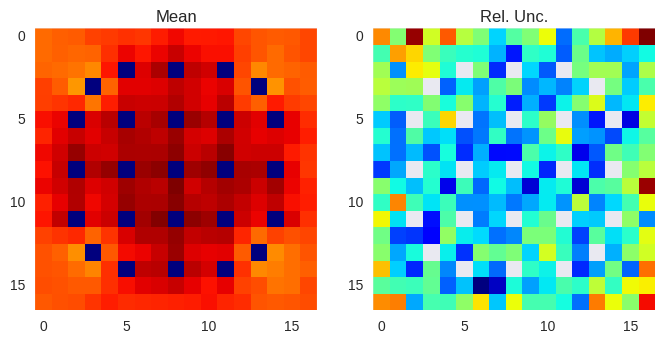

In [21]:
# Plot the mean on the left.
fig = plt.subplot(121)
plt.imshow(mean, interpolation='none', cmap='jet')
plt.title('Mean')
plt.grid(False)

# Plot the uncertainty on the right.
fig2 = plt.subplot(122)
plt.imshow(rel_err, interpolation='none', cmap='jet')
plt.title('Rel. Unc.')
plt.grid(False)

This mesh tally of fission rates particularly informative since the dark blue guide tube do not have any fission and skew the color bar. We can rectify this issue with a little trick to Matplotlib's color scheme as follows.

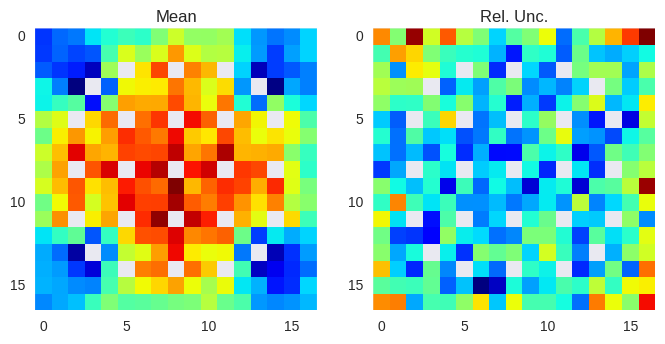

In [22]:
# Assign a NaN to zero fission rates in guide tubes
# Matplotlib will ignore "bad" values in the colorbar
mean[mean == 0.] = np.nan
cmap = plt.get_cmap('jet')
cmap.set_bad(alpha=0.)

# Plot the mean on the left.
fig = plt.subplot(121)
plt.imshow(mean, interpolation='none', cmap='jet')
plt.title('Mean')
plt.grid(False)

# Plot the uncertainty on the right.
fig2 = plt.subplot(122)
plt.imshow(rel_err, interpolation='none', cmap='jet')
plt.title('Rel. Unc.')
plt.grid(False)

### Plotting flux tallies

In [23]:
# Extract the flux mean values array
fluxes = flux.mean.flatten()

# Extend the flux array for Matplotlib's step plot
fluxes = np.insert(fluxes, 0, fluxes[0])

In [24]:
# Extract the energy bins from the Tally's EnergyFilter
energy_filter = flux.find_filter(openmc.EnergyFilter)
energies = energy_filter.bins

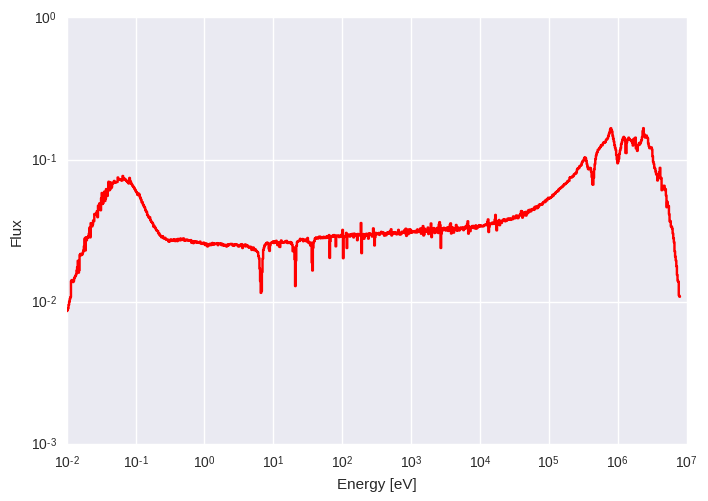

In [25]:
fig = plt.figure()
plt.loglog(energies, fluxes, drawstyle='steps', c='r')
plt.xlabel('Energy [eV]')
plt.ylabel('Flux')

### Pandas DataFames

For big, complex tallies the methods previously shown can be difficult to use.  We have more user-friendly methods based on the [Pandas](http://pandas.pydata.org/) Python package.

In [26]:
df = mesh_fiss.get_pandas_dataframe()
df.head(10)  # Show the first 10 rows

/usr/local/lib/python3.5/dist-packages/numpy/lib/shape_base.py:873: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return c.reshape(shape_out)


mesh 10000       nuclide    score      mean std. dev.
           x  y  z                                     
0          1  1  1    U235  fission  0.001659  0.000028
1          1  1  1    U238  fission  0.000104  0.000001
2          1  2  1    U235  fission  0.001684  0.000026
3          1  2  1    U238  fission  0.000103  0.000001
4          1  3  1    U235  fission  0.001693  0.000032
5          1  3  1    U238  fission  0.000105  0.000001
6          1  4  1    U235  fission  0.001748  0.000028
7          1  4  1    U238  fission  0.000106  0.000001
8          1  5  1    U235  fission  0.001769  0.000031
9          1  5  1    U238  fission  0.000105  0.000001

In [27]:
df = flux.get_pandas_dataframe()
df.head(10)

,energy low [eV],energy high [eV],nuclide,score,mean,std. dev.
0,0.010000,0.010207,total,flux,0.008592,0.000091
1,0.010207,0.010419,total,flux,0.008779,0.000104
2,0.010419,0.010635,total,flux,0.008991,0.000084
3,0.010635,0.010855,total,flux,0.009506,0.000094
4,0.010855,0.011081,total,flux,0.010004,0.000099
5,0.011081,0.011310,total,flux,0.010466,0.000116
6,0.011310,0.011545,total,flux,0.010775,0.000113
7,0.011545,0.011784,total,flux,0.013967,0.000118
8,0.011784,0.012028,total,flux,0.014180,0.000144
9,0.012028,0.012278,total,flux,0.013996,0.000132


In [28]:
df = distribcell.get_pandas_dataframe()
df.head(10)

level 1        level 2          level 3      distribcell nuclide  \
     univ   cell     lat             univ cell                       
       id     id      id  x  y  z      id   id                       
0       0  10013   10004  0  0  0   10000    1           0    U235   
1       0  10013   10004  0  0  0   10000    1           0    U235   
2       0  10013   10004  0  0  0   10000    1           0    U238   
3       0  10013   10004  0  0  0   10000    1           0    U238   
4       0  10013   10004  0  1  0   10000    1           1    U235   
5       0  10013   10004  0  1  0   10000    1           1    U235   
6       0  10013   10004  0  1  0   10000    1           1    U238   
7       0  10013   10004  0  1  0   10000    1           1    U238   
8       0  10013   10004  0  2  0   10000    1           2    U235   
9       0  10013   10004  0  2  0   10000    1           2    U235   

        score      mean std. dev.  
                                   
                                   
0  absorption  0.002005  0.000034  
1     fission  0.001659  0.000028  
2  absorption  0.001057  0.000019  
3     fission  0.000104  0.000001  
4  absorption  0.002003  0.000029  
5     fission  0.001660  0.000024  
6  absorption  0.001063  0.000017  
7     fission  0.000103  0.000001  
8  absorption  0.002023  0.000031  
9     fission  0.001678  0.000026

Pandas is a very powerful data processing tool.  One of the most important features is "fancy indexing".

In [29]:
df = mesh_fiss.get_pandas_dataframe()
sub_df = df[df['nuclide'] == 'U235']
sub_df.head(5)

/usr/local/lib/python3.5/dist-packages/numpy/lib/shape_base.py:873: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return c.reshape(shape_out)


mesh 10000       nuclide    score      mean std. dev.
           x  y  z                                     
0          1  1  1    U235  fission  0.001659  0.000028
2          1  2  1    U235  fission  0.001684  0.000026
4          1  3  1    U235  fission  0.001693  0.000032
6          1  4  1    U235  fission  0.001748  0.000028
8          1  5  1    U235  fission  0.001769  0.000031

Now consider the case where we wish to select from `sub_df` those mesh cells which have a "fission" rate that is above the average:

In [30]:
# Replace 0's with NaN to eliminate them from average
sub_df = sub_df.replace(0, np.nan)

# Extract rows corresponding to above average fission rates
indices = sub_df['mean'] > sub_df['mean'].mean()
above_avg = sub_df[indices]
above_avg.head(5)

mesh 10000        nuclide    score      mean std. dev.
            x   y  z                                     
16          1   9  1    U235  fission  0.001878  0.000028
44          2   6  1    U235  fission  0.001886  0.000027
48          2   8  1    U235  fission  0.001888  0.000026
50          2   9  1    U235  fission  0.001956  0.000024
52          2  10  1    U235  fission  0.001889  0.000027

Finally, let's use Pandas fancy indexing to select the data corresponding to those mesh cells in the lower left triangle of the mesh:

In [31]:
indices = df[('mesh 10000', 'x')] > df[('mesh 10000', 'y')]
lower = df[indices]
lower.head(5)

mesh 10000       nuclide    score      mean std. dev.
            x  y  z                                     
34          2  1  1    U235  fission  0.001660  0.000024
35          2  1  1    U238  fission  0.000103  0.000001
68          3  1  1    U235  fission  0.001678  0.000026
69          3  1  1    U238  fission  0.000105  0.000001
70          3  2  1    U235  fission  0.001658  0.000022